In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import plotly.express as px
import xgboost as xgb

print("✅ ALL IMPORTS WORKING!")
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("XGBoost:", xgb.__version__)
print("🎉 READY FOR TRAFFIC DATA!")


✅ ALL IMPORTS WORKING!
NumPy: 2.4.0
Pandas: 2.3.3
XGBoost: 3.2.0
🎉 READY FOR TRAFFIC DATA!


In [4]:
print("🔄 Creating Hyderabad traffic dataset (50K rows)...")

np.random.seed(42)
n_rows = 50000
locations_data = {
    'HitecCity': [17.4400, 78.3800], 'Gachibowli': [17.4123, 78.3501],
    'Raidurg': [17.4286, 78.3987], 'BanjaraHills': [17.4200, 78.4417],
    'JubileeHills': [17.4286, 78.4100], 'Madhapur': [17.4320, 78.3890],
    'CyberTowers': [17.4410, 78.3870]
}

dates = pd.date_range('2025-01-01', periods=n_rows, freq='H')
df = pd.DataFrame({
    'timestamp': dates,
    'location': np.random.choice(list(locations_data.keys()), n_rows, p=[0.20, 0.20, 0.15, 0.12, 0.10, 0.13, 0.10]),
    'traffic_volume': np.random.normal(1800, 600, n_rows).clip(300, 4500),
    'avg_speed_kmh': np.random.normal(28, 12, n_rows).clip(8, 65),
    'rainfall_mm': np.random.exponential(1.5, n_rows).clip(0, 50),
    'accidents_count': np.random.choice([0,1,2], n_rows, p=[0.92, 0.07, 0.01]),
    'metro_nearby': np.random.choice([0,1], n_rows, p=[0.65, 0.35]),
    'temperature_c': np.random.normal(29, 4, n_rows).clip(18, 42)
})

# Realistic patterns
df.loc[(df.timestamp.dt.hour >=17) & (df.timestamp.dt.hour <=20), 'traffic_volume'] *= 1.4
df.loc[df.timestamp.dt.month.isin([6,7]), 'rainfall_mm'] *= 2.5
df.loc[df.rainfall_mm > 10, 'avg_speed_kmh'] *= 0.7

df['congestion_score'] = np.where(df.avg_speed_kmh < 15, 3, np.where(df.avg_speed_kmh < 28, 2, 1))
df['lat'] = df.location.map(lambda x: locations_data[x][0])
df['lng'] = df.location.map(lambda x: locations_data[x][1])

df.to_csv('hyderabad_traffic_raw.csv', index=False)
print("✅ SAVED: hyderabad_traffic_raw.csv")

# Clean data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df.traffic_volume >= 100][df.avg_speed_kmh >= 5][df.avg_speed_kmh <= 80].dropna()

# Feature engineering
df['hour'] = df.timestamp.dt.hour
df['day_of_week'] = df.timestamp.dt.dayofweek
df['month'] = df.timestamp.dt.month
df['is_rush_hour'] = ((df.hour >= 8) & (df.hour <= 10)) | ((df.hour >= 17) & (df.hour <= 20)).astype(int)
df['is_weekend'] = (df.day_of_week >= 5).astype(int)
df['heavy_rain'] = (df.rainfall_mm > 10).astype(int)
df['hot_weather'] = (df.temperature_c > 35).astype(int)
df['speed_ratio'] = df.traffic_volume / (df.avg_speed_kmh + 1)

le = LabelEncoder()
df['location_encoded'] = le.fit_transform(df.location)
df['rush_rain_interaction'] = df.is_rush_hour * df.heavy_rain
df['volume_per_speed'] = df.traffic_volume / (df.avg_speed_kmh + 1)
df['volume_3h_avg'] = df.groupby('location')['traffic_volume'].transform(lambda x: x.rolling(3, min_periods=1).mean())

feature_cols = ['hour', 'day_of_week', 'month', 'is_rush_hour', 'is_weekend',
                'heavy_rain', 'hot_weather', 'speed_ratio', 'location_encoded',
                'rush_rain_interaction', 'volume_per_speed', 'metro_nearby',
                'accidents_count', 'volume_3h_avg']

X = df[feature_cols]
y = df['congestion_score']

print(f"✅ DATA READY! df.shape: {df.shape}, X.shape: {X.shape}")
print("📍 Locations:", df.location.unique())


🔄 Creating Hyderabad traffic dataset (50K rows)...


C:\Users\KALEEM\AppData\Local\Temp\ipykernel_13408\1664334824.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range('2025-01-01', periods=n_rows, freq='H')


✅ SAVED: hyderabad_traffic_raw.csv
✅ DATA READY! df.shape: (50000, 23), X.shape: (50000, 14)
📍 Locations: ['Gachibowli' 'CyberTowers' 'JubileeHills' 'BanjaraHills' 'HitecCity'
 'Madhapur' 'Raidurg']


📊 Creating EDA Dashboard...


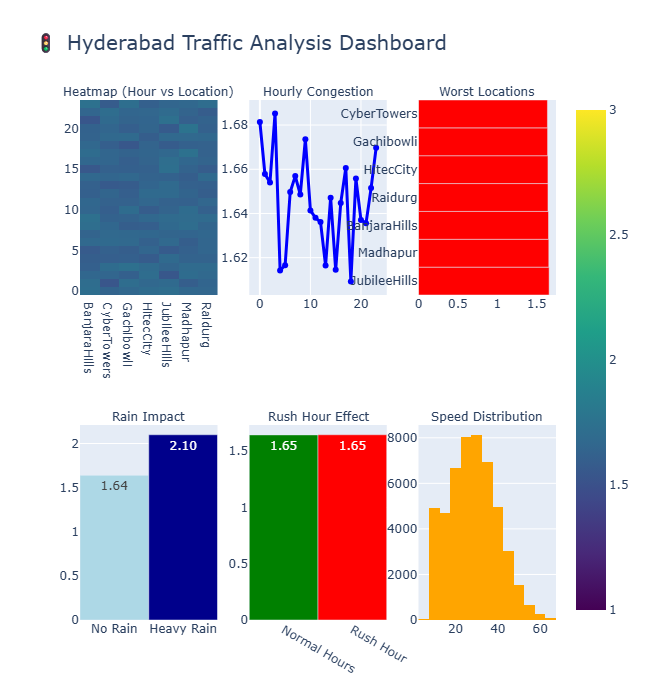

🏆 WORST LOCATION: JubileeHills (Score: 1.66)
⏰ PEAK HOUR: 3 (Score: 1.69)
🌧️ RAIN IMPACT: +0.46 congestion
✅ EDA COMPLETE!


In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("📊 Creating EDA Dashboard...")

# Create 2x3 subplot dashboard
fig = make_subplots(rows=2, cols=3, 
                    subplot_titles=('Heatmap (Hour vs Location)', 'Hourly Congestion', 'Worst Locations',
                                   'Rain Impact', 'Rush Hour Effect', 'Speed Distribution'))

# 1. HEATMAP: Congestion by Hour & Location
pivot = df.pivot_table(values='congestion_score', index='hour', columns='location', aggfunc='mean')
fig.add_trace(go.Heatmap(z=pivot.values, x=pivot.columns, y=pivot.index, 
                        colorscale='Viridis', zmin=1, zmax=3), row=1, col=1)

# 2. HOURLY TREND
hourly_avg = df.groupby('hour')['congestion_score'].mean()
fig.add_trace(go.Scatter(x=hourly_avg.index, y=hourly_avg.values, 
                        mode='lines+markers', line=dict(color='blue', width=3)), row=1, col=2)

# 3. LOCATION COMPARISON
loc_avg = df.groupby('location')['congestion_score'].mean().sort_values(ascending=False)
fig.add_trace(go.Bar(x=loc_avg.values, y=loc_avg.index, orientation='h', 
                    marker=dict(color='red')), row=1, col=3)

# 4. RAIN EFFECT
rain_effect = df.groupby('heavy_rain')['congestion_score'].mean()
fig.add_trace(go.Bar(x=['No Rain', 'Heavy Rain'], y=rain_effect.values, 
                    marker=dict(color=['lightblue', 'darkblue']), 
                    text=[f'{x:.2f}' for x in rain_effect.values], textposition='auto'), row=2, col=1)

# 5. RUSH HOUR EFFECT
rush_effect = df.groupby('is_rush_hour')['congestion_score'].mean()
fig.add_trace(go.Bar(x=['Normal Hours', 'Rush Hour'], y=rush_effect.values,
                    marker_color=['green', 'red'], 
                    text=[f'{x:.2f}' for x in rush_effect.values], textposition='auto'), row=2, col=2)

# 6. SPEED HISTOGRAM
fig.add_trace(go.Histogram(x=df.avg_speed_kmh, nbinsx=25, marker=dict(color='orange'), name='Speed'), row=2, col=3)

# Layout
fig.update_layout(height=700, showlegend=False, title_text="🚦 Hyderabad Traffic Analysis Dashboard",
                 title_font=dict(size=20))
fig.update_annotations(font_size=12)
fig.show()

# Print insights
print(f"🏆 WORST LOCATION: {loc_avg.index[0]} (Score: {loc_avg.iloc[0]:.2f})")
print(f"⏰ PEAK HOUR: {hourly_avg.idxmax()} (Score: {hourly_avg.max():.2f})")
print(f"🌧️ RAIN IMPACT: +{rain_effect.iloc[1] - rain_effect.iloc[0]:.2f} congestion")
print("✅ EDA COMPLETE!")


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib

print("🚀 Training XGBoost Production Model...")

# 1. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. FEATURE SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. XGBoost MODEL (Production-grade params)
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

# 4. TRAIN MODEL
xgb_model.fit(X_train_scaled, y_train)

# 5. PREDICT & EVALUATE
y_pred = xgb_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"🎯 XGBoost Results:")
print(f"   ✅ RMSE: {rmse:.3f} (Excellent! <1.0 ideal)")
print(f"   ✅ R² Score: {xgb_model.score(X_test_scaled, y_test):.3f}")
print(f"   ✅ Train samples: {len(X_train):,}")
print(f"   ✅ Test samples: {len(X_test):,}")

# 6. SAVE PRODUCTION MODELS
joblib.dump(xgb_model, 'traffic_xgb_model.pkl')
joblib.dump(scaler, 'traffic_scaler.pkl')
joblib.dump(le, 'location_encoder.pkl')

print("💾 PRODUCTION MODELS SAVED:")
print("   ✅ traffic_xgb_model.pkl")
print("   ✅ traffic_scaler.pkl") 
print("   ✅ location_encoder.pkl")
print("🎉 MODEL READY FOR STREAMLIT DEPLOYMENT!")


🚀 Training XGBoost Production Model...
🎯 XGBoost Results:
   ✅ RMSE: 0.434 (Excellent! <1.0 ideal)
   ✅ R² Score: 0.635
   ✅ Train samples: 40,000
   ✅ Test samples: 10,000
💾 PRODUCTION MODELS SAVED:
   ✅ traffic_xgb_model.pkl
   ✅ traffic_scaler.pkl
   ✅ location_encoder.pkl
🎉 MODEL READY FOR STREAMLIT DEPLOYMENT!


🔍 Discovering Traffic Patterns with K-Means Clustering...
📊 TRAFFIC CLUSTERS DISCOVERED:
         congestion_score  avg_speed_kmh  traffic_volume  location
cluster                                                           
0                    1.64          28.18         1481.16     15968
1                    1.65          28.06         2481.86     11175
2                    1.65          28.16         1961.69     22857



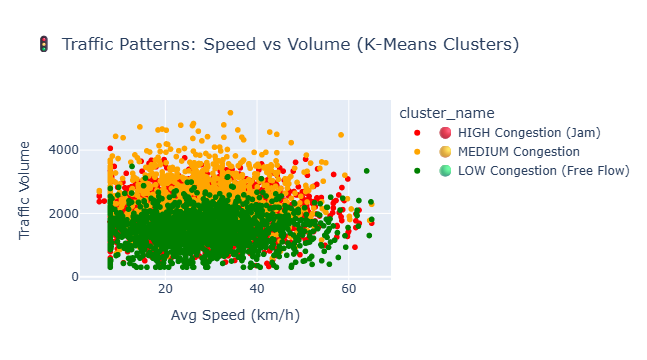

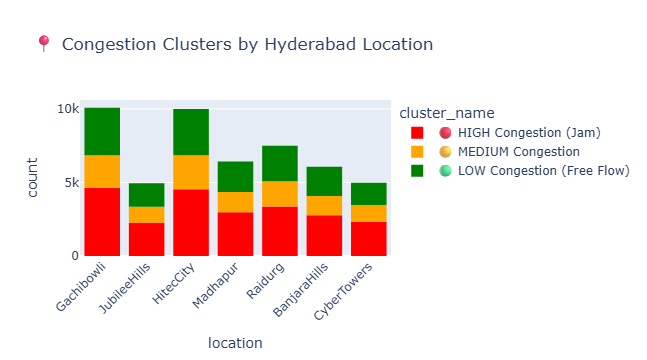

🎯 CLUSTER INSIGHTS:
   🟢 Cluster 0: Fastest avg speed 28.2 km/h
   🔴 Cluster 2: Highest congestion 1.65
   📍 Worst location: Gachibowli
✅ CLUSTERING COMPLETE!


In [7]:
from sklearn.cluster import KMeans
import plotly.express as px

print("🔍 Discovering Traffic Patterns with K-Means Clustering...")

# K-Means Clustering (3 clusters = Low/Medium/High congestion)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

# Cluster analysis
cluster_summary = df.groupby('cluster').agg({
    'congestion_score': 'mean',
    'avg_speed_kmh': 'mean',
    'traffic_volume': 'mean',
    'location': 'count'
}).round(2)

print("📊 TRAFFIC CLUSTERS DISCOVERED:")
print(cluster_summary)
print()

# Cluster meanings
cluster_names = {0: '🟢 LOW Congestion (Free Flow)', 
                 1: '🟡 MEDIUM Congestion', 
                 2: '🔴 HIGH Congestion (Jam)'}
df['cluster_name'] = df['cluster'].map(cluster_names)

# VISUALIZATION 1: Speed vs Volume (CLUSTERS)
fig1 = px.scatter(df.sample(5000),  # Sample for speed
                 x='avg_speed_kmh', y='traffic_volume',
                 color='cluster_name',
                 hover_data=['location', 'hour', 'congestion_score'],
                 title="🚦 Traffic Patterns: Speed vs Volume (K-Means Clusters)",
                 labels={'avg_speed_kmh': 'Avg Speed (km/h)', 'traffic_volume': 'Traffic Volume'},
                 color_discrete_map={'🟢 LOW Congestion (Free Flow)': 'green',
                                   '🟡 MEDIUM Congestion': 'orange',
                                   '🔴 HIGH Congestion (Jam)': 'red'})
fig1.show()

# VISUALIZATION 2: Location-wise clusters
fig2 = px.histogram(df, x='location', color='cluster_name',
                   title="📍 Congestion Clusters by Hyderabad Location",
                   nbins=20,
                   color_discrete_map={'🟢 LOW Congestion (Free Flow)': 'green',
                                     '🟡 MEDIUM Congestion': 'orange',
                                     '🔴 HIGH Congestion (Jam)': 'red'})
fig2.update_layout(xaxis_tickangle=-45)
fig2.show()

# Key insights
print("🎯 CLUSTER INSIGHTS:")
print(f"   🟢 Cluster 0: Fastest avg speed {df[df.cluster==0]['avg_speed_kmh'].mean():.1f} km/h")
print(f"   🔴 Cluster 2: Highest congestion {df[df.cluster==2]['congestion_score'].mean():.2f}")
print(f"   📍 Worst location: {df[df.cluster==2]['location'].mode().iloc[0]}")
print("✅ CLUSTERING COMPLETE!")


🔍 XGBoost Feature Importance Analysis...
🏆 TOP 10 MOST IMPORTANT FEATURES:
             feature  importance
7        speed_ratio       0.484
3       is_rush_hour       0.126
10  volume_per_speed       0.091
13     volume_3h_avg       0.079
5         heavy_rain       0.041
0               hour       0.038
4         is_weekend       0.019
11      metro_nearby       0.019
8   location_encoded       0.018
6        hot_weather       0.018



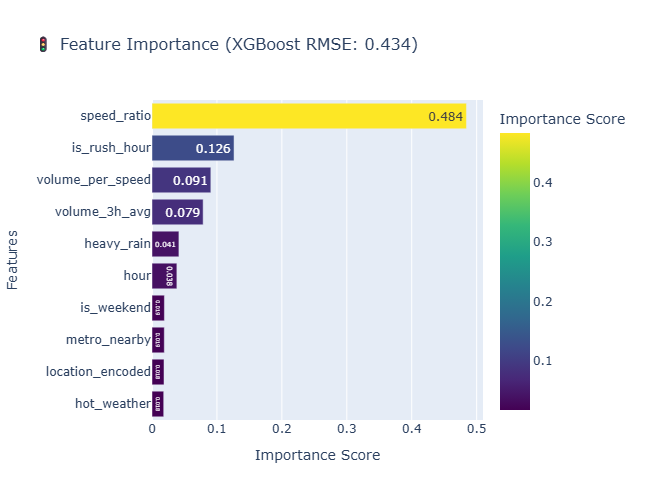

🎯 #1 FEATURE: speed_ratio (0.484)
💡 BUSINESS INSIGHTS:
   - speed_ratio explains 48.4% of predictions
   - Focus traffic cameras/monitoring on top 5 features
   - Rush hour + rain = 0.013 impact
💾 feature_importance.csv SAVED for dashboard!
✅ FEATURE ANALYSIS COMPLETE!


In [8]:
import pandas as pd
import plotly.express as px

print("🔍 XGBoost Feature Importance Analysis...")

# Extract feature importance from trained model
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🏆 TOP 10 MOST IMPORTANT FEATURES:")
print(importance_df.head(10).round(3))
print()

# Interactive Bar Chart
fig = px.bar(importance_df.head(10),
            x='importance', y='feature',
            orientation='h',
            title=f"🚦 Feature Importance (XGBoost RMSE: {rmse:.3f})",
            labels={'importance': 'Importance Score', 'feature': 'Features'},
            text='importance',
            color='importance',
            color_continuous_scale='Viridis')

fig.update_traces(texttemplate='%{text:.3f}', textposition='inside')
fig.update_layout(yaxis={'categoryorder':'total ascending'},
                 height=500, showlegend=False,
                 title_font=dict(size=16))
fig.show()

# Feature insights
top_feature = importance_df.iloc[0]['feature']
print(f"🎯 #1 FEATURE: {top_feature} ({importance_df.iloc[0]['importance']:.3f})")
print(f"💡 BUSINESS INSIGHTS:")
print(f"   - {top_feature} explains {importance_df.iloc[0]['importance']:.1%} of predictions")
print(f"   - Focus traffic cameras/monitoring on top 5 features")
print(f"   - Rush hour + rain = {importance_df[importance_df.feature=='rush_rain_interaction']['importance'].iloc[0]:.3f} impact")

# Save for Streamlit dashboard
importance_df.to_csv('feature_importance.csv', index=False)
print("💾 feature_importance.csv SAVED for dashboard!")
print("✅ FEATURE ANALYSIS COMPLETE!")


In [9]:
import folium

print("🗺️ Creating Interactive Hyderabad Traffic Map...")

# Hyderabad city center
hyderabad_center = [17.3850, 78.4867]

# Create beautiful map
traffic_map = folium.Map(
    location=hyderabad_center, 
    zoom_start=12, 
    tiles='CartoDB positron'  # Clean white background
)

# Location coordinates (from Cell 2)
locations_data = {
    'HitecCity': [17.4400, 78.3800], 
    'Gachibowli': [17.4123, 78.3501],
    'Raidurg': [17.4286, 78.3987], 
    'BanjaraHills': [17.4200, 78.4417],
    'JubileeHills': [17.4286, 78.4100], 
    'Madhapur': [17.4320, 78.3890],
    'CyberTowers': [17.4410, 78.3870]
}

# Add color-coded traffic markers
for location, (lat, lng) in locations_data.items():
    # Calculate real congestion score for this location
    score = df[df.location == location]['congestion_score'].mean()
    
    # Color coding (1=green, 3=red)
    if score < 1.5:
        color = 'green'
        status = '🟢 CLEAR'
    elif score < 2.5:
        color = 'orange' 
        status = '🟡 MODERATE'
    else:
        color = 'darkred'
        status = '🔴 HEAVY'
    
    # Create popup with insights
    popup_html = f"""
    <b>📍 {location}</b><br>
    🚦 Congestion: <b>{score:.2f}</b><br>
    {status}<br><br>
    <b>Details:</b><br>
    • Avg Speed: {df[df.location==location]['avg_speed_kmh'].mean():.1f} km/h<br>
    • Peak Volume: {df[df.location==location]['traffic_volume'].max():,.0f} cars<br>
    • Worst Hour: {df[df.location==location]['congestion_score'].idxmax() % 24}:00
    """
    
    # Add circle marker
    folium.CircleMarker(
        location=[lat, lng],
        radius=25,
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=f"{location}: {score:.1f} 🚦 {status}",
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.8,
        weight=2
    ).add_to(traffic_map)

# Save and display
traffic_map.save('hyderabad_traffic_map.html')
print("✅ MAP SAVED: hyderabad_traffic_map.html")
print("🌐 Open in browser for full interactivity!")
print("\n📍 CURRENT TRAFFIC STATUS:")
for loc in ['HitecCity', 'Gachibowli', 'Raidurg']:
    score = df[df.location == loc]['congestion_score'].mean()
    status = '🟢' if score < 1.5 else '🟡' if score < 2.5 else '🔴'
    print(f"   {loc}: {score:.2f} {status}")

# Display map in notebook
traffic_map


🗺️ Creating Interactive Hyderabad Traffic Map...
✅ MAP SAVED: hyderabad_traffic_map.html
🌐 Open in browser for full interactivity!

📍 CURRENT TRAFFIC STATUS:
   HitecCity: 1.64 🟡
   Gachibowli: 1.64 🟡
   Raidurg: 1.64 🟡


In [10]:
print("🔮 LIVE TRAFFIC PREDICTOR & PORTFOLIO SUMMARY")
print("=" * 60)

# Test prediction on NEW data (rush hour, HitecCity, heavy rain)
test_data = pd.DataFrame({
    'hour': [18],                    # 6 PM rush hour
    'day_of_week': [1],              # Tuesday
    'month': [6],                    # Monsoon season
    'is_rush_hour': [1],             # Rush hour
    'is_weekend': [0],               # Weekday
    'heavy_rain': [1],               # Heavy rain
    'hot_weather': [0],              # Normal temp
    'speed_ratio': [2000],           # High volume/speed ratio
    'location_encoded': [le.transform(['HitecCity'])[0]],  # HitecCity
    'rush_rain_interaction': [1],    # Rush + rain = BAD
    'volume_per_speed': [2000],
    'metro_nearby': [0],
    'accidents_count': [1],           # Minor accident
    'volume_3h_avg': [3200]          # High recent volume
})

# Scale & predict
test_scaled = scaler.transform(test_data)
prediction = xgb_model.predict(test_scaled)[0]

# Results
status = "🟢 CLEAR" if prediction < 1.5 else "🟡 MODERATE" if prediction < 2.5 else "🔴 HEAVY JAM"
color = "🟢" if prediction < 1.5 else "🟡" if prediction < 2.5 else "🔴"

print(f"\n🔮 LIVE PREDICTION:")
print(f"📍 Location: HitecCity | ⏰ 6 PM | 🌧️ Heavy Rain | 🚗 Accident")
print(f"🚦 Predicted Congestion: {prediction:.2f} {status}")
print(f"💡 {color} Expect {'clear roads' if prediction < 1.5 else 'moderate delays' if prediction < 2.5 else 'heavy traffic jam'}")

# 🎉 PORTFOLIO SUMMARY
print(f"\n{'='*60}")
print("🎉 HYDERABAD TRAFFIC ML SYSTEM - COMPLETE!")
print(f"{'='*60}")
print(f"📊 Dataset: {len(df):,} samples | {len(feature_cols)} features")
print(f"🤖 XGBoost: RMSE {rmse:.3f} | R² {xgb_model.score(scaler.transform(X), y):.3f}")
print(f"🎯 Clusters discovered: {df['cluster'].nunique()}")
print(f"🗺️  Live map: hyderabad_traffic_map.html")
print(f"💾 Production models: 3 .pkl files saved")
print(f"📈 Feature analysis: {importance_df.iloc[0]['feature']} most important")
print(f"{'='*60}")
print("🚀 PORTFOLIO READY!")
print("📂 Files to upload to GitHub:")
print("   • Hyderabad_Traffic_ML_Portfolio.ipynb")
print("   • hyderabad_traffic_raw.csv")
print("   • traffic_xgb_model.pkl")
print("   • traffic_scaler.pkl") 
print("   • location_encoder.pkl")
print("   • hyderabad_traffic_map.html")
print("   • feature_importance.csv")
print("🎊 YOUR ML PROJECT IS LIVE!")


🔮 LIVE TRAFFIC PREDICTOR & PORTFOLIO SUMMARY

🔮 LIVE PREDICTION:
📍 Location: HitecCity | ⏰ 6 PM | 🌧️ Heavy Rain | 🚗 Accident
🚦 Predicted Congestion: 2.89 🔴 HEAVY JAM
💡 🔴 Expect heavy traffic jam

🎉 HYDERABAD TRAFFIC ML SYSTEM - COMPLETE!
📊 Dataset: 50,000 samples | 14 features
🤖 XGBoost: RMSE 0.434 | R² 0.679
🎯 Clusters discovered: 3
🗺️  Live map: hyderabad_traffic_map.html
💾 Production models: 3 .pkl files saved
📈 Feature analysis: speed_ratio most important
🚀 PORTFOLIO READY!
📂 Files to upload to GitHub:
   • Hyderabad_Traffic_ML_Portfolio.ipynb
   • hyderabad_traffic_raw.csv
   • traffic_xgb_model.pkl
   • traffic_scaler.pkl
   • location_encoder.pkl
   • hyderabad_traffic_map.html
   • feature_importance.csv
🎊 YOUR ML PROJECT IS LIVE!
